**Predicting Sales Prices**

1.       Introduction

Selling a home could be stressful, especially when preparing to sell it. This may include putting some money into renovations, but the question is, what kind of things should you concentrate on to raise the value of the home. In this study I am going to be using the 3.  Ames Housing dataset from Dean De Cook and use advance regression techniques to predict the price of homes based on these characteristics.

**Importing the recommended packages for Python**

In [1]:
# This first set of packages include Pandas, for data manipulation, numpy for mathematical computation and matplotlib & seaborn, for visualisation.
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
print('Basic Packages and Visualization Packages Imported...')

# Set visualisation colours
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)

# Stats Package
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

# Metrics used for measuring the accuracy and performance of the models
from sklearn import metrics
from sklearn.metrics import mean_squared_error
print('Metrics Packages Imported...')

# Algorithms used for modeling
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
print('Algorithm Packages Imported..')

# Pipeline and scaling preprocessing will be used for models that are sensitive
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and Preprocessing Packages Imported...')

# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model Packages Imported...')



# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation Warning will be ignored...')

Basic Packages and Visualization Packages Imported...
Metrics Packages Imported...
Algorithm Packages Imported..
Pipeline and Preprocessing Packages Imported...
Model Packages Imported...
Deprecation Warning will be ignored...


**2.0 Data Exploration**

When loading the Aims dataset, the dataset was already split by the training and test data, but I still need to understand the data before I perform any analysis. 4. Marcelino identifies 3 items to look at when exploring a dataset such as:
1.	Understand the problem. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
2.	Univariable study. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
3.	Multivariate study. We'll try to understand how the dependent variable and independent variables relate.

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
print('Training and Test Data imported...')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Drop Id from train and test data
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("\nTraining: {}".format(train.shape))
print("Test: {}".format(test.shape))
train.head()

Training and Test Data imported...

Training: (1460, 80)
Test: (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


As we can tell from the above:
* The **training data** has 1460 observations
* The **test data** has 1459 observations

**Lets find out more about the different columns in the data:**

In [3]:
# Count the column types
train.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

There are two data types I noticed from looking at the different columns:
1. Numerical
2. Categorical
3. Continuous Numbers

That being said, I will tackle this problem in the data manipulation portion. Where I plan to use **'Hot Encoding'** to change the data from numerical to categorical

Since we are predicting the 'SalePrice', lets figure out more about it

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


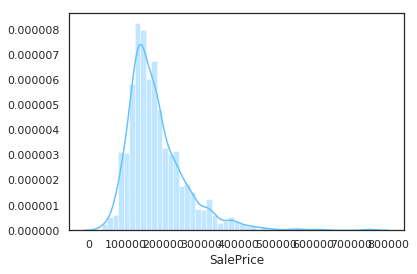

In [5]:
#histogram of SalePrice
sns.distplot(train['SalePrice']);

From the above, what we could tell from the SalePrice is that the data is not normally distributed, positvely skewed.
We tackle this later in code when we will use the **Box Cox Transformation** to normalize the datasoure.

Now lets find out what variables are correlated with 'SalePrice', I will look at the top 10 correlated variables:

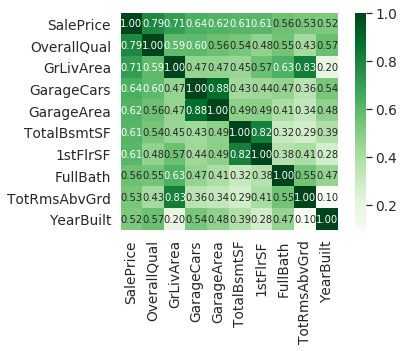

In [6]:
#saleprice correlation matrix
correlation = train.corr()
k = 10 #number of variables for heatmap
corr = correlation.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[corr].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="Greens", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corr.values, xticklabels=corr.values)
plt.show()

What we could tell from the correlation above is that top 10 variables that have the highest correlation with 'SalePrice' is:
1. OverallQual
2. GrLivArea
3. GarageCars
4. GarageArea
5. TotalBsmtSF
6. 1stFlrSF
7. FullBath
8. TotRmsAbvGrd
9. YearBuilt

With that being said, lets look deeper into 'OverallQual', 'GrLivArea', 'GarageCars' and Its Correlation to 'SalePrice' to make sure this true.

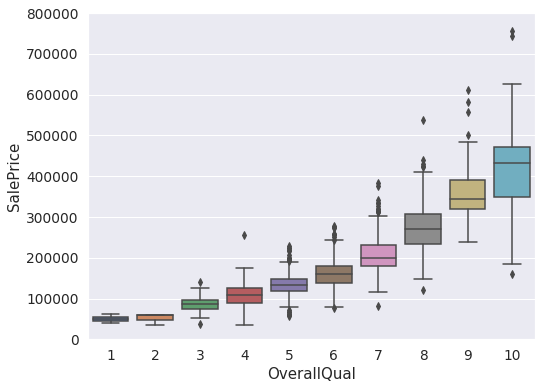

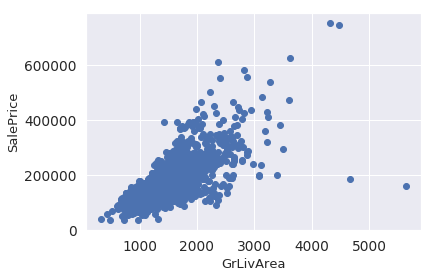

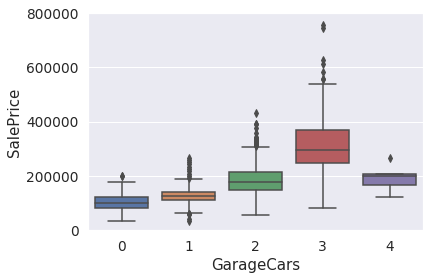

In [7]:
#OverallQual
var = 'OverallQual'
vis = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=vis)
fig.axis(ymin=0, ymax=800000);

#GrLivArea
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


#GarageCars
var = 'GarageCars'
vis = pd.concat([train['SalePrice'], train[var]], axis=1)
fig = sns.boxplot(x=var, y="SalePrice", data=vis)
fig.axis(ymin=0, ymax=800000);

When looking at all of the three graphs above, we notice they all have a positive correlation with 'SalePrice'.

I did noticed GrLivArea, had a couple of outliers. This is important to address because as Ng noted, outliers and missing values will skew the prediction model. What I did to fix this is remove any points where GrLivArea< 4000 and SalePrice< 700000.

Therefore, we can safely drop them.

**Feature Selection**

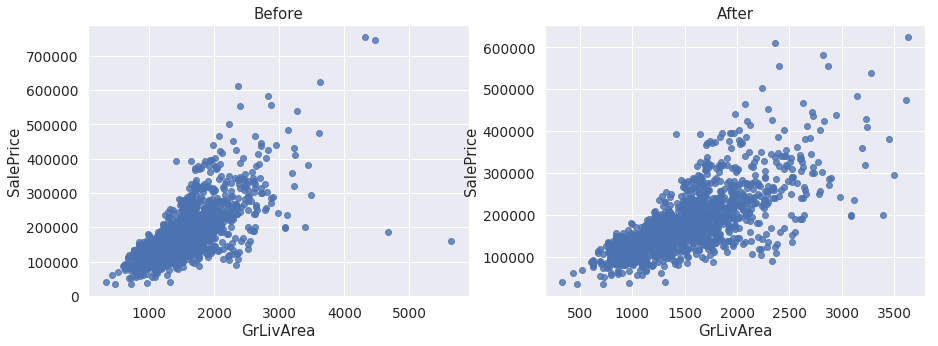

In [8]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['GrLivArea']>4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("After")

We have now removed the four outliers.

In [9]:
#Save the length of train and test data so we could split later when we split later when we do modelling at the end!
ntrain = train.shape[0]
ntest = test.shape[0]

# Also save the target value, as we will remove this
targetval = train.SalePrice.values

# concatenate training and test data into data
data = pd.concat((train, test)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)

print("Concated Data Shape: {}".format(data.shape))

Concated Data Shape: (2915, 79)


**Missing Data**

One of the hardest questions I tackled when doing this project is, what do I do with the missing values? But, before I start deleting any features, there are a couple of questions that need to be answered:
1.	How prevalent is the missing data?
2.	Is the missing data random or does it have a pattern?
The answer to these questions is important for practical reasons because missing data can give us an answer whether or not we will be imputing or removing a feature. This can prevent us from proceeding with the analysis and achieving a proper predictive analysis.

When analyzing figure 3, features like PoolQC, MiscFeature, Alley, Fence, FireplaceQu and, Lotfrontage have a lot of features missing. As Diewart explains, when evaluating a price of a home, look at the amenities and quality build of the home, so deleting these features will be out of the question. Instead the two things I  did instead to treat missing values is:
1.	Features that have a count change NA to ‘0’. 
2.	Features that are nominal use the mode.
3.	Features that don’t have any predictive power like utilities, drop the feature.


In [10]:
# Using data description, fill these missing values with "None"
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MSSubClass", "MasVnrType"):
    data[col] = data[col].fillna("None")
print("'None' - treated...")

# The area of the lot out front is likely to be similar to the houses in the local neighbourhood
# Therefore, let's use the median value of the houses in the neighbourhood to fill this feature
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
print("'LotFrontage' - treated...")

# Using data description, fill these missing values with 0 
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    data[col] = data[col].fillna(0)
print("'0' - treated...")


# Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])
data["Functional"] = data["Functional"].fillna(data['Functional'].mode()[0])
print("'mode' - treated...")

data_na = data.isnull().sum()
print("Features with missing values: ", data_na.drop(data_na[data_na == 0].index))

'None' - treated...
'LotFrontage' - treated...
'0' - treated...
'mode' - treated...
Features with missing values:  Utilities    2
dtype: int64


In [11]:
# From inspection, we can remove Utilities
data = data.drop(['Utilities'], axis=1)

data_na = data.isnull().sum()
print("Features with missing values: ", len(data_na.drop(data_na[data_na == 0].index)))

Features with missing values:  0


**Feature Engineering**

When looking at the different relationships between 'SalePrice' and x, not all features have a linear relationship. What I have done to solve this problem is apply linear, quadratic and, cubic function so that the data points will be able to fit onto the curve. Let me give you some background information on these three functions. 

Typically, you choose the model order by the number of bends you need in your line. Each increase in the exponent produces one more bend in the curved fitted line. 1. "If your response data follows a pattern that descends down to a lower bound, or ascends up to an upper bound, you can fit this type of relationship by including the reciprocal (1/x) of one or more predictor variables in the model. Generally, you want to use this form when the size of effect for a predictor variable decreases as its value increases. Because the gradient is a function of 1/x, the gradient gets flatter as x increases. For this type of model, x can never equal 0 because you can’t divide by zero."

In [12]:
#All the features that are in metrics:

# Quadratic
data["OverallQual-2"] = data["OverallQual"] ** 2
data["GrLivArea-2"] = data["GrLivArea"] ** 2
data["GarageCars-2"] = data["GarageCars"] ** 2
data["GarageArea-2"] = data["GarageArea"] ** 2
data["TotalBsmtSF-2"] = data["TotalBsmtSF"] ** 2
data["1stFlrSF-2"] = data["1stFlrSF"] ** 2
data["FullBath-2"] = data["FullBath"] ** 2
data["TotRmsAbvGrd-2"] = data["TotRmsAbvGrd"] ** 2
data["Fireplaces-2"] = data["Fireplaces"] ** 2
data["MasVnrArea-2"] = data["MasVnrArea"] ** 2
data["BsmtFinSF1-2"] = data["BsmtFinSF1"] ** 2
data["LotFrontage-2"] = data["LotFrontage"] ** 2
data["WoodDeckSF-2"] = data["WoodDeckSF"] ** 2
data["OpenPorchSF-2"] = data["OpenPorchSF"] ** 2
data["2ndFlrSF-2"] = data["2ndFlrSF"] ** 2
print("Quadratics done!...")

# Cubic
data["OverallQual-3"] = data["OverallQual"] ** 3
data["GrLivArea-3"] = data["GrLivArea"] ** 3
data["GarageCars-3"] = data["GarageCars"] ** 3
data["GarageArea-3"] = data["GarageArea"] ** 3
data["TotalBsmtSF-3"] = data["TotalBsmtSF"] ** 3
data["1stFlrSF-3"] = data["1stFlrSF"] ** 3
data["FullBath-3"] = data["FullBath"] ** 3
data["TotRmsAbvGrd-3"] = data["TotRmsAbvGrd"] ** 3
data["Fireplaces-3"] = data["Fireplaces"] ** 3
data["MasVnrArea-3"] = data["MasVnrArea"] ** 3
data["BsmtFinSF1-3"] = data["BsmtFinSF1"] ** 3
data["LotFrontage-3"] = data["LotFrontage"] ** 3
data["WoodDeckSF-3"] = data["WoodDeckSF"] ** 3
data["OpenPorchSF-3"] = data["OpenPorchSF"] ** 3
data["2ndFlrSF-3"] = data["2ndFlrSF"] ** 3
print("Cubics done!...")

# Square Root
data["OverallQual-Sq"] = np.sqrt(data["OverallQual"])
data["GrLivArea-Sq"] = np.sqrt(data["GrLivArea"])
data["GarageCars-Sq"] = np.sqrt(data["GarageCars"])
data["GarageArea-Sq"] = np.sqrt(data["GarageArea"])
data["TotalBsmtSF-Sq"] = np.sqrt(data["TotalBsmtSF"])
data["1stFlrSF-Sq"] = np.sqrt(data["1stFlrSF"])
data["FullBath-Sq"] = np.sqrt(data["FullBath"])
data["TotRmsAbvGrd-Sq"] = np.sqrt(data["TotRmsAbvGrd"])
data["Fireplaces-Sq"] = np.sqrt(data["Fireplaces"])
data["MasVnrArea-Sq"] = np.sqrt(data["MasVnrArea"])
data["BsmtFinSF1-Sq"] = np.sqrt(data["BsmtFinSF1"])
data["LotFrontage-Sq"] = np.sqrt(data["LotFrontage"])
data["WoodDeckSF-Sq"] = np.sqrt(data["WoodDeckSF"])
data["OpenPorchSF-Sq"] = np.sqrt(data["OpenPorchSF"])
data["2ndFlrSF-Sq"] = np.sqrt(data["2ndFlrSF"])
print("Roots done!...")

Quadratics done!...
Cubics done!...
Roots done!...


**Transforming the data**

As Noted, there are three types of data in the Ames dataset:
1. Nominal
2. Categorical
3. Continuous Numbers

What I plan to do is change the features that are categoric or continuous to  nominal, this is an important step as having different data types will give an error when we start modelling.
The second thing I did was remove any variables that have no predictive value, like Utilities.

In [13]:
#Basement Quality
data['BsmtQual'] = data['BsmtQual'].map({"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
#Basement Condition
data['BsmtCond'] = data['BsmtCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
#Basement Exposure
data['BsmtExposure'] = data['BsmtExposure'].map({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})
#BsmtFinType
data = pd.get_dummies(data, columns = ["BsmtFinType1"], prefix="BsmtFinType1")
#BsmtFinSF1_Band
data['BsmtFinSF1_Band'] = pd.cut(data['BsmtFinSF1'], 4)

#BsmtFinSF1
data.loc[data['BsmtFinSF1']<=1002.5, 'BsmtFinSF1'] = 1
data.loc[(data['BsmtFinSF1']>1002.5) & (data['BsmtFinSF1']<=2005), 'BsmtFinSF1'] = 2
data.loc[(data['BsmtFinSF1']>2005) & (data['BsmtFinSF1']<=3007.5), 'BsmtFinSF1'] = 3
data.loc[data['BsmtFinSF1']>3007.5, 'BsmtFinSF1'] = 4
data['BsmtFinSF1'] = data['BsmtFinSF1'].astype(int)
data.drop('BsmtFinSF1_Band', axis=1, inplace=True)
data = pd.get_dummies(data, columns = ["BsmtFinSF1"], prefix="BsmtFinSF1")

#BsmtFinType2
data = pd.get_dummies(data, columns = ["BsmtFinType2"], prefix="BsmtFinType2")
data['BsmtFinSf2_Flag'] = data['BsmtFinSF2'].map(lambda x:0 if x==0 else 1)
data.drop('BsmtFinSF2', axis=1, inplace=True)

#BsmtUnfSF_Band
data['BsmtUnfSF_Band'] = pd.cut(data['BsmtUnfSF'], 3)

data.loc[data['BsmtUnfSF']<=778.667, 'BsmtUnfSF'] = 1
data.loc[(data['BsmtUnfSF']>778.667) & (data['BsmtUnfSF']<=1557.333), 'BsmtUnfSF'] = 2
data.loc[data['BsmtUnfSF']>1557.333, 'BsmtUnfSF'] = 3
data['BsmtUnfSF'] = data['BsmtUnfSF'].astype(int)

data.drop('BsmtUnfSF_Band', axis=1, inplace=True)

data = pd.get_dummies(data, columns = ["BsmtUnfSF"], prefix="BsmtUnfSF")

#totalBsmtSF_Band
data['TotalBsmtSF_Band'] = pd.cut(data['TotalBsmtSF'], 10)

data.loc[data['TotalBsmtSF']<=509.5, 'TotalBsmtSF'] = 1
data.loc[(data['TotalBsmtSF']>509.5) & (data['TotalBsmtSF']<=1019), 'TotalBsmtSF'] = 2
data.loc[(data['TotalBsmtSF']>1019) & (data['TotalBsmtSF']<=1528.5), 'TotalBsmtSF'] = 3
data.loc[(data['TotalBsmtSF']>1528.5) & (data['TotalBsmtSF']<=2038), 'TotalBsmtSF'] = 4
data.loc[(data['TotalBsmtSF']>2038) & (data['TotalBsmtSF']<=2547.5), 'TotalBsmtSF'] = 5
data.loc[(data['TotalBsmtSF']>2547.5) & (data['TotalBsmtSF']<=3057), 'TotalBsmtSF'] = 6
data.loc[(data['TotalBsmtSF']>3057) & (data['TotalBsmtSF']<=3566.5), 'TotalBsmtSF'] = 7
data.loc[data['TotalBsmtSF']>3566.5, 'TotalBsmtSF'] = 8
data['TotalBsmtSF'] = data['TotalBsmtSF'].astype(int)

data.drop('TotalBsmtSF_Band', axis=1, inplace=True)

data = pd.get_dummies(data, columns = ["TotalBsmtSF"], prefix="TotalBsmtSF")

In [14]:
#1stFlrSF_Band'
data['1stFlrSF_Band'] = pd.cut(data['1stFlrSF'], 6)
data['1stFlrSF_Band'].unique()

data.loc[data['1stFlrSF']<=1127.5, '1stFlrSF'] = 1
data.loc[(data['1stFlrSF']>1127.5) & (data['1stFlrSF']<=1921), '1stFlrSF'] = 2
data.loc[(data['1stFlrSF']>1921) & (data['1stFlrSF']<=2714.5), '1stFlrSF'] = 3
data.loc[(data['1stFlrSF']>2714.5) & (data['1stFlrSF']<=3508), '1stFlrSF'] = 4
data.loc[(data['1stFlrSF']>3508) & (data['1stFlrSF']<=4301.5), '1stFlrSF'] = 5
data.loc[data['1stFlrSF']>4301.5, '1stFlrSF'] = 6
data['1stFlrSF'] = data['1stFlrSF'].astype(int)

data.drop('1stFlrSF_Band', axis=1, inplace=True)

data = pd.get_dummies(data, columns = ["1stFlrSF"], prefix="1stFlrSF")

#2ndFlrSF_Band'
data['2ndFlrSF_Band'] = pd.cut(data['2ndFlrSF'], 6)
data['2ndFlrSF_Band'].unique()

data.loc[data['2ndFlrSF']<=310.333, '2ndFlrSF'] = 1
data.loc[(data['2ndFlrSF']>310.333) & (data['2ndFlrSF']<=620.667), '2ndFlrSF'] = 2
data.loc[(data['2ndFlrSF']>620.667) & (data['2ndFlrSF']<=931), '2ndFlrSF'] = 3
data.loc[(data['2ndFlrSF']>931) & (data['2ndFlrSF']<=1241.333), '2ndFlrSF'] = 4
data.loc[(data['2ndFlrSF']>1241.333) & (data['2ndFlrSF']<=1551.667), '2ndFlrSF'] = 5
data.loc[data['2ndFlrSF']>1551.667, '2ndFlrSF'] = 6
data['2ndFlrSF'] = data['2ndFlrSF'].astype(int)

data.drop('2ndFlrSF_Band', axis=1, inplace=True)

data = pd.get_dummies(data, columns = ["2ndFlrSF"], prefix="2ndFlrSF")

In [15]:
#GrivArea
data['GrLivArea_Band'] = pd.cut(data['GrLivArea'], 6)

data.loc[data['GrLivArea']<=1127.5, 'GrLivArea'] = 1
data.loc[(data['GrLivArea']>1127.5) & (data['GrLivArea']<=1921), 'GrLivArea'] = 2
data.loc[(data['GrLivArea']>1921) & (data['GrLivArea']<=2714.5), 'GrLivArea'] = 3
data.loc[(data['GrLivArea']>2714.5) & (data['GrLivArea']<=3508), 'GrLivArea'] = 4
data.loc[(data['GrLivArea']>3508) & (data['GrLivArea']<=4301.5), 'GrLivArea'] = 5
data.loc[data['GrLivArea']>4301.5, 'GrLivArea'] = 6
data['GrLivArea'] = data['GrLivArea'].astype(int)

data.drop('GrLivArea_Band', axis=1, inplace=True)
data = pd.get_dummies(data, columns = ["GrLivArea"], prefix="GrLivArea")

In [16]:
#Number of baths
data['TotalBathrooms'] = data['BsmtHalfBath'] + data['BsmtFullBath'] + data['HalfBath'] + data['FullBath']

columns = ['BsmtHalfBath', 'BsmtFullBath', 'HalfBath', 'FullBath']
data.drop(columns, axis=1, inplace=True)

In [17]:
#Kitchen Quality
data['KitchenQual'] = data['KitchenQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
data['KitchenQual'].unique()

array([3, 2, 4, 1])

In [18]:
#Fire Place Quality
data['FireplaceQu'] = data['FireplaceQu'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

In [19]:
#MSSubClass
data['MSSubClass'] = data['MSSubClass'].astype(str)
data = pd.get_dummies(data, columns = ["MSSubClass"], prefix="MSSubClass")

In [20]:
#BldgType
data['BldgType'] = data['BldgType'].astype(str)
data = pd.get_dummies(data, columns = ["BldgType"], prefix="BldgType")

In [21]:
#HouseStyle
data['HouseStyle'] = data['HouseStyle'].map({"2Story":"2Story", "1Story":"1Story", "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", 
                                                     "SFoyer":"SFoyer", "SLvl":"SLvl", "2.5Unf":"2.5Story", "2.5Fin":"2.5Story"})
data = pd.get_dummies(data, columns = ["HouseStyle"], prefix="HouseStyle")

In [22]:
#Remodelling to Categorical
train['Remod_Diff'] = train['YearRemodAdd'] - train['YearBuilt']
data['Remod_Diff'] = data['YearRemodAdd'] - data['YearBuilt']
data.drop('YearRemodAdd', axis=1, inplace=True)

In [23]:
#Year Built
data['YearBuilt_Band'] = pd.cut(data['YearBuilt'], 7)
data['YearBuilt_Band'].unique()
data['YearBuilt_Band'] = pd.cut(data['YearBuilt'], 7)
data['YearBuilt_Band'].unique()
data.loc[data['YearBuilt']<=1892, 'YearBuilt'] = 1
data.loc[(data['YearBuilt']>1892) & (data['YearBuilt']<=1911), 'YearBuilt'] = 2
data.loc[(data['YearBuilt']>1911) & (data['YearBuilt']<=1931), 'YearBuilt'] = 3
data.loc[(data['YearBuilt']>1931) & (data['YearBuilt']<=1951), 'YearBuilt'] = 4
data.loc[(data['YearBuilt']>1951) & (data['YearBuilt']<=1971), 'YearBuilt'] = 5
data.loc[(data['YearBuilt']>1971) & (data['YearBuilt']<=1990), 'YearBuilt'] = 6
data.loc[data['YearBuilt']>1990, 'YearBuilt'] = 7
data['YearBuilt'] = data['YearBuilt'].astype(int)

data.drop('YearBuilt_Band', axis=1, inplace=True)
data = pd.get_dummies(data, columns = ["YearBuilt"], prefix="YearBuilt")

In [24]:
#LowQualFinSF
data['LowQualFinSF_Flag'] = data['LowQualFinSF'].map(lambda x:0 if x==0 else 1)
data.drop('LowQualFinSF', axis=1, inplace=True)

In [25]:
#Foundation
data = pd.get_dummies(data, columns = ["Foundation"], prefix="Foundation")

In [26]:
#Functional
data['Functional'] = data['Functional'].map({"Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7})
data['Functional'].unique()

array([7, 6, 3, 5, 4, 2, 1])

In [27]:
#Roofstyle
data = pd.get_dummies(data, columns = ["RoofStyle"], prefix="RoofStyle")

In [28]:
#Roof Material
data = pd.get_dummies(data, columns = ["RoofMatl"], prefix="RoofMatl")

In [29]:
#Exterior1st and 2nd floor
def Exter2(col):
    if col['Exterior2nd'] == col['Exterior1st']:
        return 1
    else:
        return 0
    
data['ExteriorMatch_Flag'] = data.apply(Exter2, axis=1)
data.drop('Exterior2nd', axis=1, inplace=True)

data = pd.get_dummies(data, columns = ["Exterior1st"], prefix="Exterior1st")

#External Quality
data['ExterQual'] = data['ExterQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})

#External Condition
data = pd.get_dummies(data, columns = ["ExterCond"], prefix="ExterCond")

In [30]:
#Masonry veneer type
data = pd.get_dummies(data, columns = ["MasVnrType"], prefix="MasVnrType")

#MasVnrArea - No correlation to the SalePrice
data.drop('MasVnrArea', axis=1, inplace=True)

In [31]:
#GarageType
data = pd.get_dummies(data, columns = ["GarageType"], prefix="GarageType")

#Year garage was built
data['GarageYrBlt_Band'] = pd.qcut(data['GarageYrBlt'], 3)
data['GarageYrBlt_Band'].unique()

data.loc[data['GarageYrBlt']<=1964, 'GarageYrBlt'] = 1
data.loc[(data['GarageYrBlt']>1964) & (data['GarageYrBlt']<=1996), 'GarageYrBlt'] = 2
data.loc[data['GarageYrBlt']>1996, 'GarageYrBlt'] = 3
data['GarageYrBlt'] = data['GarageYrBlt'].astype(int)

data.drop('GarageYrBlt_Band', axis=1, inplace=True)
data = pd.get_dummies(data, columns = ["GarageYrBlt"], prefix="GarageYrBlt")

In [32]:
#Garage Finish
data = pd.get_dummies(data, columns = ["GarageFinish"], prefix="GarageFinish")

#GarageArea_Band
data['GarageArea_Band'] = pd.cut(data['GarageArea'], 3)
data['GarageArea_Band'].unique()

data.loc[data['GarageArea']<=496, 'GarageArea'] = 1
data.loc[(data['GarageArea']>496) & (data['GarageArea']<=992), 'GarageArea'] = 2
data.loc[data['GarageArea']>992, 'GarageArea'] = 3
data['GarageArea'] = data['GarageArea'].astype(int)

data.drop('GarageArea_Band', axis=1, inplace=True)

data = pd.get_dummies(data, columns = ["GarageArea"], prefix="GarageArea")

#Garage Quality
data['GarageQual'] = data['GarageQual'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
data['GarageQual'].unique()
data = pd.get_dummies(data, columns = ["GarageQual"], prefix="GarageQual")

#Garage Condition
data['GarageCond'] = data['GarageCond'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
data['GarageCond'].unique()
data = pd.get_dummies(data, columns = ["GarageCond"], prefix="GarageCond")

In [33]:
#Fence
data = pd.get_dummies(data, columns = ["Fence"], prefix="Fence")

In [34]:
#Wooddeck
def WoodDeckFlag(col):
    if col['WoodDeckSF'] == 0:
        return 1
    else:
        return 0
    
data['NoWoodDeck_Flag'] = data.apply(WoodDeckFlag, axis=1)

data['WoodDeckSF_Band'] = pd.cut(data['WoodDeckSF'], 4)

data.loc[data['WoodDeckSF']<=356, 'WoodDeckSF'] = 1
data.loc[(data['WoodDeckSF']>356) & (data['WoodDeckSF']<=712), 'WoodDeckSF'] = 2
data.loc[(data['WoodDeckSF']>712) & (data['WoodDeckSF']<=1068), 'WoodDeckSF'] = 3
data.loc[data['WoodDeckSF']>1068, 'WoodDeckSF'] = 4
data['WoodDeckSF'] = data['WoodDeckSF'].astype(int)
data.drop('WoodDeckSF_Band', axis=1, inplace=True)

data = pd.get_dummies(data, columns = ["WoodDeckSF"], prefix="WoodDeckSF")

#Total Surface Area of Porch

data['TotalPorchSF'] = data['OpenPorchSF'] + data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch'] 
train['TotalPorchSF'] = train['OpenPorchSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

def PorchFlag(col):
    if col['TotalPorchSF'] == 0:
        return 1
    else:
        return 0
    
data['NoPorch_Flag'] = data.apply(PorchFlag, axis=1)

data['TotalPorchSF_Band'] = pd.cut(data['TotalPorchSF'], 4)
data['TotalPorchSF_Band'].unique()

data.loc[data['TotalPorchSF']<=431, 'TotalPorchSF'] = 1
data.loc[(data['TotalPorchSF']>431) & (data['TotalPorchSF']<=862), 'TotalPorchSF'] = 2
data.loc[(data['TotalPorchSF']>862) & (data['TotalPorchSF']<=1293), 'TotalPorchSF'] = 3
data.loc[data['TotalPorchSF']>1293, 'TotalPorchSF'] = 4
data['TotalPorchSF'] = data['TotalPorchSF'].astype(int)

data.drop('TotalPorchSF_Band', axis=1, inplace=True)
data = pd.get_dummies(data, columns = ["TotalPorchSF"], prefix="TotalPorchSF")

In [35]:
#Pool Area
def PoolFlag(col):
    if col['PoolArea'] == 0:
        return 0
    else:
        return 1
data['HasPool_Flag'] = data.apply(PoolFlag, axis=1)
data.drop('PoolArea', axis=1, inplace=True)

#PoolQC - Not correlated to Price will drop
data.drop('PoolQC', axis=1, inplace=True)

In [36]:
#Zoning Classification
data = pd.get_dummies(data, columns = ["MSZoning"], prefix="MSZoning")

In [37]:
#Neightborhood
data = pd.get_dummies(data, columns = ["Neighborhood"], prefix="Neighborhood")

In [38]:
#Condition
data['Condition1'] = data['Condition1'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
data['Condition2'] = data['Condition2'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
def ConditionMatch(col):
    if col['Condition1'] == col['Condition2']:
        return 0
    else:
        return 1
    
data['Diff2ndCondition_Flag'] = data.apply(ConditionMatch, axis=1)
data.drop('Condition2', axis=1, inplace=True)

data = pd.get_dummies(data, columns = ["Condition1"], prefix="Condition1")

In [39]:
#Lot ARea
data['LotArea_Band'] = pd.qcut(data['LotArea'], 8)
data['LotArea_Band'].unique()

data.loc[data['LotArea']<=5684.75, 'LotArea'] = 1
data.loc[(data['LotArea']>5684.75) & (data['LotArea']<=7474), 'LotArea'] = 2
data.loc[(data['LotArea']>7474) & (data['LotArea']<=8520), 'LotArea'] = 3
data.loc[(data['LotArea']>8520) & (data['LotArea']<=9450), 'LotArea'] = 4
data.loc[(data['LotArea']>9450) & (data['LotArea']<=10355.25), 'LotArea'] = 5
data.loc[(data['LotArea']>10355.25) & (data['LotArea']<=11554.25), 'LotArea'] = 6
data.loc[(data['LotArea']>11554.25) & (data['LotArea']<=13613), 'LotArea'] = 7
data.loc[data['LotArea']>13613, 'LotArea'] = 8
data['LotArea'] = data['LotArea'].astype(int)

data.drop('LotArea_Band', axis=1, inplace=True)
data = pd.get_dummies(data, columns = ["LotArea"], prefix="LotArea")

#LotShape
data = pd.get_dummies(data, columns = ["LotShape"], prefix="LotShape")

#Land Contour
data = pd.get_dummies(data, columns = ["LandContour"], prefix="LandContour")

#LotConfig
data['LotConfig'] = data['LotConfig'].map({"Inside":"Inside", "FR2":"FR", "Corner":"Corner", "CulDSac":"CulDSac", "FR3":"FR"})
data = pd.get_dummies(data, columns = ["LotConfig"], prefix="LotConfig")

#Landslope
data['LandSlope'] = data['LandSlope'].map({"Gtl":1, "Mod":2, "Sev":2})

def Slope(col):
    if col['LandSlope'] == 1:
        return 1
    else:
        return 0
    
data['GentleSlope_Flag'] = data.apply(Slope, axis=1)
data.drop('LandSlope', axis=1, inplace=True)

In [40]:
#Street - No Correlation
data.drop('Street', axis=1, inplace=True) 

#Alley
data = pd.get_dummies(data, columns = ["Alley"], prefix="Alley")

#Paved Driveway
data = pd.get_dummies(data, columns = ["PavedDrive"], prefix="PavedDrive")

In [41]:
#Heating
data['GasA_Flag'] = data['Heating'].map({"GasA":1, "GasW":0, "Grav":0, "Wall":0, "OthW":0, "Floor":0})
data.drop('Heating', axis=1, inplace=True)

#Heating Quality
data['HeatingQC'] = data['HeatingQC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

#Central Air
data['CentralAir'] = data['CentralAir'].map({"Y":1, "N":0})

In [42]:
#Electrical
data['Electrical'] = data['Electrical'].map({"SBrkr":"SBrkr", "FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse", "Mix":"Mix"})
data = pd.get_dummies(data, columns = ["Electrical"], prefix="Electrical")

In [43]:
#MiscFEature - drop no correlation
columns=['MiscFeature', 'MiscVal']
data.drop(columns, axis=1, inplace=True)

In [44]:
#MoSold
data = pd.get_dummies(data, columns = ["MoSold"], prefix="MoSold")

In [45]:
#YearSold
data = pd.get_dummies(data, columns = ["YrSold"], prefix="YrSold")

In [46]:
#Saletype
data['SaleType'] = data['SaleType'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", "ConLI":"Oth", 
                                                 "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})
data = pd.get_dummies(data, columns = ["SaleType"], prefix="SaleType")


In [47]:
#Sale Condition
data = pd.get_dummies(data, columns = ["SaleCondition"], prefix="SaleCondition")

Now that the data is now all the same, we are going to be **Looking at the Distribution**

As we noticed from our data exploration section, the data is positively skewed.  By not having a normal distribution may be cause by such as: 2. Measurement error, missing data, data corruption and rare events. What we could do to treat this is, by removing outliers, setting thresholds and transforming the data. By transforming the data, we will be able to get a more accurate result. What I have done to transform the data is a log1p transformation which applies log(1+x) to all elements within the feature.

Another method I applied is a Box-Cox Transformation. 2. This method is able to perform a range of power transformations including the log and square root. This method can be configured to evaluate a suite of transformations automatically and select the best fit. With the Box-Cox, the data will be more linear and be better distributed.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


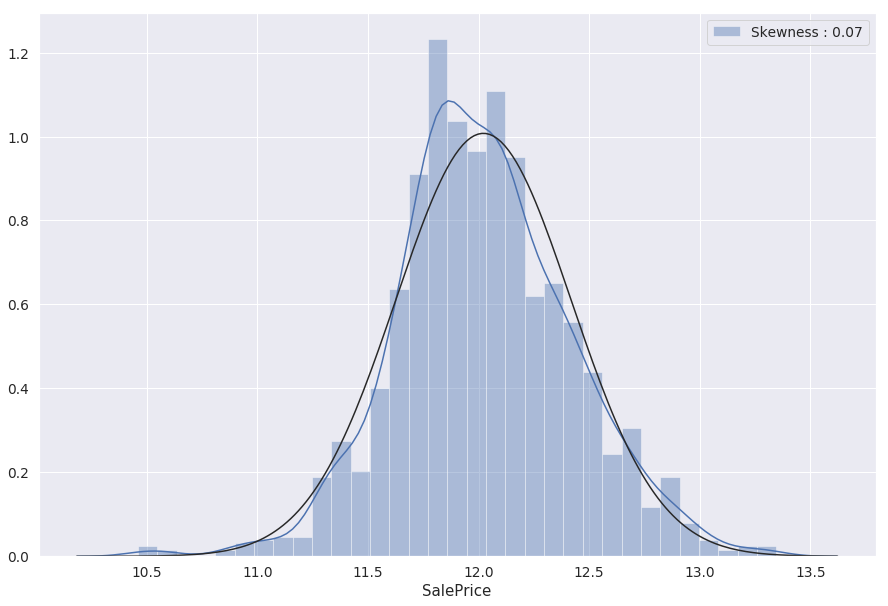

In [48]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
targetval = train["SalePrice"]

#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

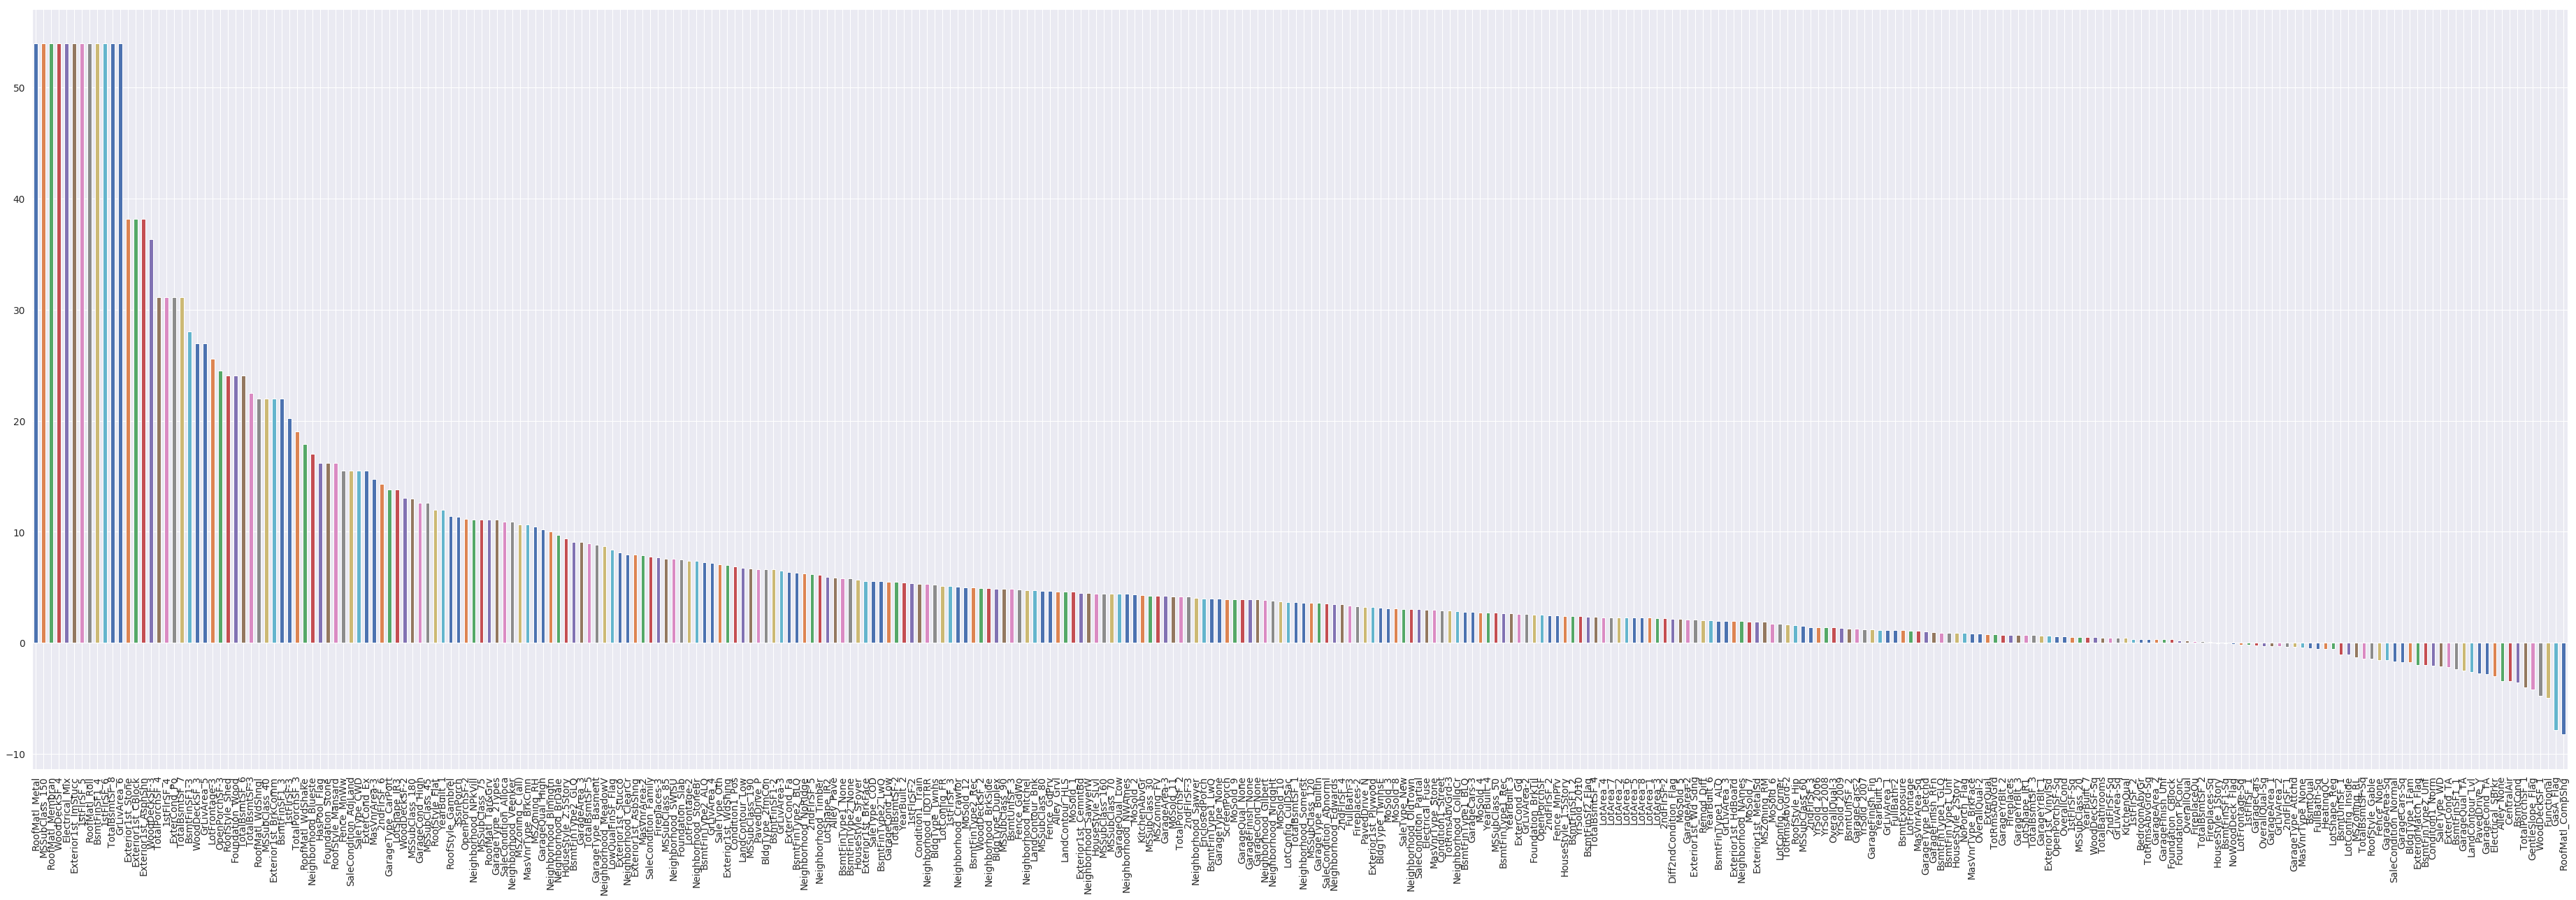

In [49]:
# First lets single out the numeric features
numeric_feats = data.dtypes[data.dtypes != "object"].index

# Check how skewed they are
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

plt.subplots(figsize =(65, 20))
skewed_feats.plot(kind='bar');

**Box Cox Transformation**

It is:

In [50]:
skewness = skewed_feats[abs(skewed_feats) > 0.5]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

302 skewed numerical features have been Box-Cox transformed


**Data Modelling**

In [51]:
# First, re-create the training and test datasets
train = data[:ntrain]
test = data[ntrain:]

print(train.shape)
print(test.shape)

(1456, 330)
(1459, 330)


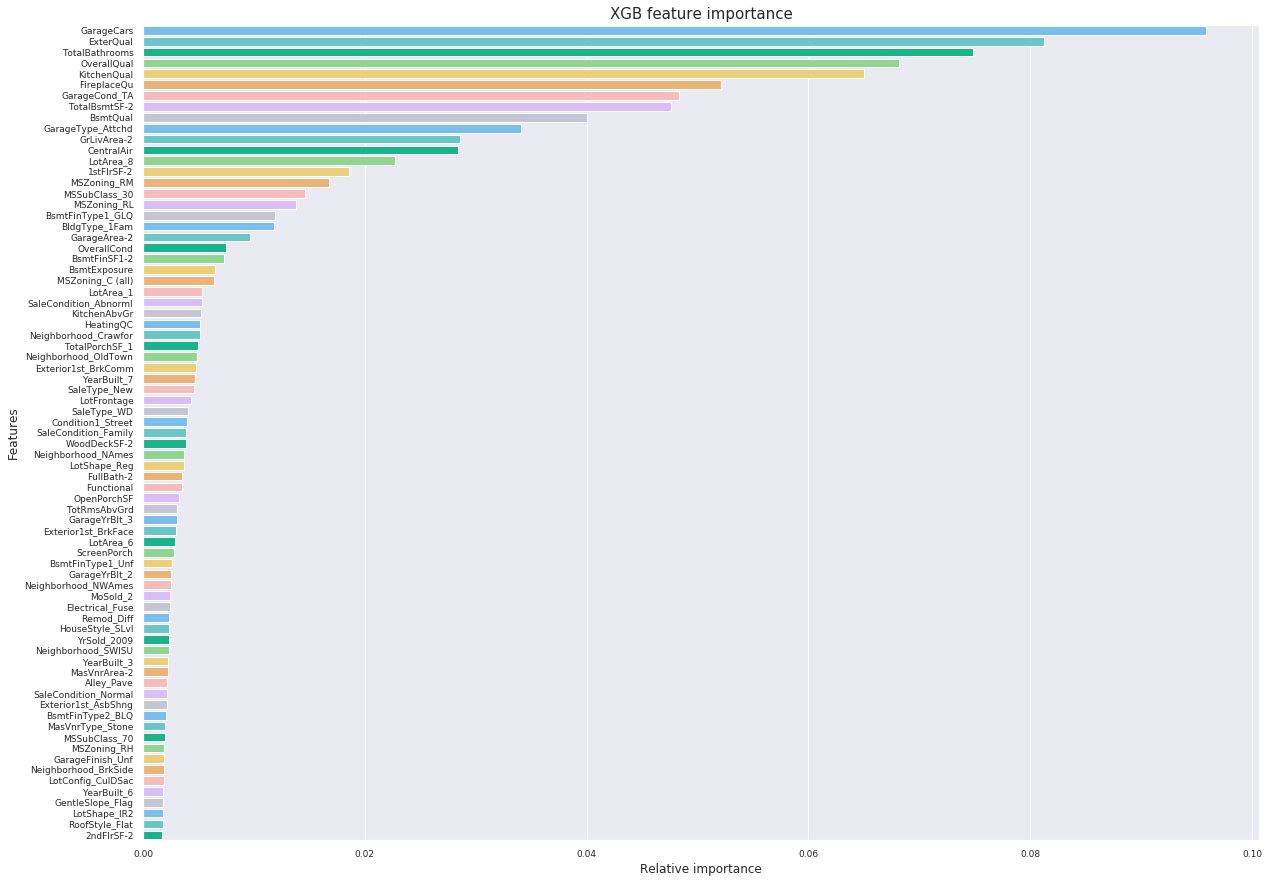

In [52]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(train, targetval)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(model.feature_importances_)[::-1]
indices = indices[:75]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=train.columns[indices], x = model.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance");

In [53]:
xgb_train = train.copy()
xgb_test = test.copy()

import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(xgb_train, targetval)

# Allow the feature importances attribute to select the most important features
xgb_feat_red = SelectFromModel(model, prefit = True)

# Reduce estimation, validation and test datasets
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

Results of 'feature_importances_':
X_train:  (1456, 46) 
X_test:  (1459, 46)


In [54]:
# Next we want to sample our training data to test for performance of robustness ans accuracy, before applying to the test data
X_train, X_test, targetval, Y_test = model_selection.train_test_split(xgb_train, targetval, test_size=0.3, random_state=42)

Prediction

In [55]:
import xgboost as xgb
#Machine Learning Algorithm (MLA) Selection and Initialization
models = [KernelRidge(), ElasticNet(), Lasso(), BayesianRidge(), RandomForestRegressor(), xgb.XGBRegressor()]

#Shufflesplit to randomize the crossvalidation
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#Comparison Visualization
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

#Save the performance of the models
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, targetval)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    training_results = np.sqrt((-cross_val_score(alg, X_train, targetval, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 BayesianRidge trained...


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5 RandomForestRegressor trained...
6 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...",31.481,32.361
1,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",22.118,22.629
2,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",27.129,27.394
3,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",11.370,11.796
4,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",14.143,14.937
5,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",12.490,12.307


What we could see from the output from the XGBoost is that Bayesian gave us the best output.

In [56]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, targetval)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...",11.369,11.895
1,ElasticNet,"{'alpha': 0.001, 'copy_X': True, 'fit_intercep...",11.485,11.984
2,Lasso,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",11.462,11.880
3,GradientBoostingRegressor,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",12.242,12.204
4,BayesianRidge,"{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...",11.370,11.796
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 1e...",11.845,12.365
6,RandomForestRegressor,"{'max_depth': None, 'max_features': 'auto', 'm...",13.632,13.825
7,XGBRegressor,"{'booster': 'gbtree', 'colsample_bylevel': 0.2...",12.331,12.278


**Stacked Method**

The steps for this technique are shown below:

1.    Create a set of algorithms ready for stacking - We've done this...
2.    Split the original training data into a training and validation sample - We've done this too...
3.    Train the algorithms on the training sample - Also done this...
4.    For each algorithm, apply the trained models to the validation dataset and create a set of predictions, 1 column for each model, as a new table. Call this the new training dataset.
5.    Also apply the trained algorithm to the test dataset and create a final set of predictions, 1 column for each model, as a new table. Call this new test dataset.
6.    For the new training dataset, we have labeled outputs, in the form of Y_test. Now we must train another model on these two feature sets: new training dataset and Y_test.
7.    Use this newly trained model to predict values for new test dataset.

In [57]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, targetval)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc = row_index, column = names[0], value = gs_best.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = names[0], value = gs_best.predict(xgb_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    names.pop(0)
    
    row_index+=1
    
print('Done')

1 KernelRidge predictions added to stacking validation dataset...
1 KernelRidge predictions added to stacking test dataset...
--------------------------------------------------
2 ElasticNet predictions added to stacking validation dataset...
2 ElasticNet predictions added to stacking test dataset...
--------------------------------------------------
3 Lasso predictions added to stacking validation dataset...
3 Lasso predictions added to stacking test dataset...
--------------------------------------------------
4 GradientBoostingRegressor predictions added to stacking validation dataset...
4 GradientBoostingRegressor predictions added to stacking test dataset...
--------------------------------------------------
5 BayesianRidge predictions added to stacking validation dataset...
5 BayesianRidge predictions added to stacking test dataset...
--------------------------------------------------
6 LassoLarsIC predictions added to stacking validation dataset...
6 LassoLarsIC predictions added

In [58]:
stacked_validation_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,12.096690,12.099652,12.098992,12.103465,12.095698,12.105647,12.172177,12.027501
1,11.969683,11.969540,11.969694,12.062550,11.974408,12.001969,12.068800,12.100253
2,11.799011,11.803136,11.809414,11.861925,11.806491,11.784670,11.886538,11.767135
3,11.828576,11.818937,11.824847,11.794636,11.833641,11.844075,11.795615,11.784371
4,11.272813,11.256220,11.260323,11.142435,11.273972,11.291386,11.347292,11.246760


In [59]:
stacked_test_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,11.619698,11.633833,11.631306,11.716773,11.626053,11.641160,11.747533,11.739241
1,12.043976,12.048462,12.048335,11.967372,12.044099,12.005887,11.988422,12.019146
2,12.132444,12.127544,12.130211,12.165663,12.135377,12.067179,12.079751,12.148486
3,12.204719,12.208533,12.209058,12.159255,12.205850,12.137975,12.122189,12.199407
4,12.127927,12.140245,12.137429,12.144096,12.125076,12.171797,12.149708,12.158028


In [60]:
# First drop the Lasso results from the table, as we will be using Lasso as the meta-model
drop = ['Lasso']
stacked_validation_train.drop(drop, axis=1, inplace=True)
stacked_test_train.drop(drop, axis=1, inplace=True)

# Now fit the meta model and generate predictions
meta_model = make_pipeline(RobustScaler(), Lasso(alpha=0.00001, copy_X = True, fit_intercept = True,
                                              normalize = False, precompute = False, max_iter = 10000,
                                              tol = 0.0001, selection = 'random', random_state = None))
meta_model.fit(stacked_validation_train, Y_test)

meta_model_pred = np.expm1(meta_model.predict(stacked_test_train))
print("Meta-model trained and applied!...")

Meta-model trained and applied!...


In [61]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(stacked_validation_train, Y_test)
    gs_best = gs_alg.best_estimator_
    final_predictions.insert(loc = row_index, column = names[0], value = np.expm1(gs_best.predict(stacked_test_train)))
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    names.pop(0)
    
    row_index+=1

print("-"*50)
print("Done")
    
final_predictions.head()

1 KernelRidge final results predicted added to table...
2 ElasticNet final results predicted added to table...
3 Lasso final results predicted added to table...
4 GradientBoostingRegressor final results predicted added to table...
5 BayesianRidge final results predicted added to table...
6 LassoLarsIC final results predicted added to table...
7 RandomForestRegressor final results predicted added to table...
8 XGBRegressor final results predicted added to table...
--------------------------------------------------
Done


,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,117154.259191,117394.638747,113745.815133,110427.460316,117290.523029,116858.343405,93702.309646,105148.953125
1,165532.107317,164957.817595,167595.137547,170427.594078,165706.138029,164944.025561,169744.595964,170562.437500
2,188017.720286,188286.183004,187025.587237,183731.270029,190715.705175,188373.815536,183100.700330,173300.312500
3,196866.413845,196351.967092,198005.359040,192491.648369,198308.545556,196353.095160,190526.330242,191509.296875
4,186887.542505,186539.814812,185239.423358,187440.615201,184932.006777,186107.724699,186572.170573,183568.203125


In [62]:
ensemble = meta_model_pred*(1/10) + final_predictions['XGBoost']*(1.5/10) + final_predictions['Gradient Boosting']*(2/10) + final_predictions['Bayesian Ridge']*(1/10) + final_predictions['Lasso']*(1/10) + final_predictions['KernelRidge']*(1/10) + final_predictions['Lasso Lars IC']*(1/10) + final_predictions['Random Forest']*(1.5/10)

submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = ensemble
#submission.to_csv('final_submission.csv',index=False)
print("Submission file, created!")

Submission file, created!
